In [266]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
import lightmotif

In [200]:
cs_data_file = '../data/TB000208a.outputs.xlsx'
data_path = '../data/TB000208a'
train_sheets = ['GT-Rep1-N7_S1','GT-Rep2-N7_S2','GT-Rep3-N7_S3']
test_sheets = ['Pool-Rep1-N7_S4','Pool-Rep2-N7_S5','Pool-Rep3-N7_S6']

## Load Cryptic-Seq Data Files

In [208]:
# GT_rep1 = pd.read_excel(cs_data_file, sheet_name=train_sheets[0])
# GT_rep2 = pd.read_excel(cs_data_file, sheet_name=train_sheets[1])
# GT_rep3 = pd.read_excel(cs_data_file, sheet_name=train_sheets[2])

Pool_rep1 = pd.read_excel(cs_data_file, sheet_name=test_sheets[0])
Pool_rep2 = pd.read_excel(cs_data_file, sheet_name=test_sheets[1])
Pool_rep3 = pd.read_excel(cs_data_file, sheet_name=test_sheets[2])

Pool_rep1_seq_deduped = Pool_rep1.drop_duplicates(subset='seq')
Pool_rep2_seq_deduped = Pool_rep2.drop_duplicates(subset='seq')
Pool_rep3_seq_deduped = Pool_rep3.drop_duplicates(subset='seq')

# Merge the CS dataframes on chrom, start, end, dinucleotide, and donor
cryptic_seq_df = pd.merge(Pool_rep1_seq_deduped, Pool_rep2_seq_deduped, on=['chrom','seq_start','seq_end','genome_dinucleotide','donor'], how='outer')
cryptic_seq_df = pd.merge(cryptic_seq_df, Pool_rep3_seq_deduped, on=['chrom','seq_start','seq_end','genome_dinucleotide','donor'], how='outer')

# set NAs 
cryptic_seq_df['count'] = cryptic_seq_df['count'].fillna(0)
cryptic_seq_df['count_x'] = cryptic_seq_df['count_x'].fillna(0)
cryptic_seq_df['count_y'] = cryptic_seq_df['count_y'].fillna(0)

# Add the counts from each DataFrame
cryptic_seq_df['total_count'] = cryptic_seq_df['count'] + cryptic_seq_df['count_x'] + cryptic_seq_df['count_y']

# Optionally, drop the original count columns
cryptic_seq_df.drop(columns=['count', 'count_x','count_y'], inplace=True)

cryptic_seq_df['dinucleotide_position'] = cryptic_seq_df[['dinucleotide_position','dinucleotide_position_x','dinucleotide_position_y']].mode(axis=1)[0]

cryptic_seq_df.drop(columns=['dinucleotide_position_x','dinucleotide_position_y'], inplace=True)

cryptic_seq_df['strand'] = cryptic_seq_df[['strand','strand_x','strand_y']].mode(axis=1)[0]

cryptic_seq_df.drop(columns=['strand_x','strand_y'], inplace=True)

cryptic_seq_df['sequence'] = cryptic_seq_df[['seq','seq_x','seq_y']].mode(axis=1)[0]

cryptic_seq_df.drop(columns=['seq','seq_x','seq_y'], inplace=True)

cryptic_seq_df.columns = ['donor','central_dinucleotide','chrom','start','end','dinucleotide_position','strand','total_count','sequence']

In [209]:
cryptic_seq_df

,donor,central_dinucleotide,chrom,start,end,dinucleotide_position,strand,total_count,sequence
0,attP-TG,TG,chr14_KI270724v1_random,1401,1446,1422.0,-,21632.0,TGCGGGTTTGCGGGCAACCGCCTGGGCTGTGGGAGGAGCCCGGGCA
1,attP-TG,TG,chr14_GL000225v1_random,54345,54390,54366.0,+,10277.0,CACGGGTTTGCGGGCAGCCGCATGGGCTGTGGGAGCAGCCCGGGCA
2,attP-CA,CA,chr14_GL000225v1_random,44324,44369,44345.0,-,8004.0,TGCCCGGGCTGCTCCCACAGCCCAGGCAGCTGCCCGCAAACCCGCG
3,attP-TG,TG,chr17,31561265,31561310,31561286.0,-,7531.0,TCCCATAATTCTGACATCTGCATGTTCCACTGGGTAAGCCTCCAGG
4,attP-CA,CA,chr14_KI270723v1_random,36190,36235,36211.0,-,7165.0,TACCCGGGCTCCTCCCACAGCCCAGGCGGTTGCCCGCAAACCCGCG
...,...,...,...,...,...,...,...,...,...
167921,attP-CT,CT,chr8,20130041,20130086,20130062.0,+,1.0,GCACCGAAATCAGTCTTTAGAGCTCGCTGTGGCCACAAGTGGGTGC
167922,attP-GT,GT,chr8,20248942,20248987,20248963.0,+,1.0,GTCTATGGCTTAAAGAAGAGTGGTCACCGAGGTCAAAGGTCACTGG
167923,attP-TG,TG,chr8,20302350,20302395,20302371.0,-,1.0,CATATGGGTATTAGAGATAGCATGTACAGACGGGAAAGGTGTTTGT
167924,attP-AC,AC,chr8,20305208,20305253,20305229.0,-,1.0,GGCACTATCTTGGCTCACTGCAACCTCTGCCTTCCAGGCTCAAGCA


## Create binary and weighted cryptic-seq logos

In [211]:
weighted_seqs = []
binary_seqs = []
for index,row in cryptic_seq_df.iterrows():
    count = row['total_count']
    seq = row['sequence']
    rv_seq = str(Seq(seq).reverse_complement())
    if 'N' in seq or 'N' in rv_seq:
        continue
    for i in range(int(count)):
        seq_no_dinucleotide = seq[0:22] + 'NN' + seq[24:]
        rv_seq_no_dinucleotide = rv_seq[0:22] + 'NN' + rv_seq[24:]
        weighted_seqs.append(seq_no_dinucleotide)
        weighted_seqs.append(rv_seq_no_dinucleotide)
    binary_seqs.append(seq_no_dinucleotide)
    binary_seqs.append(rv_seq_no_dinucleotide)
    
# Initialize a dictionary with lists to hold counts for each base
weighted_base_counts = {'A': [0] * len(weighted_seqs[0]), 'T': [0] * len(weighted_seqs[0]),
               'C': [0] * len(weighted_seqs[0]), 'G': [0] * len(weighted_seqs[0])}

# Initialize a dictionary with lists to hold counts for each base
binary_base_counts = {'A': [0] * len(binary_seqs[0]), 'T': [0] * len(binary_seqs[0]),
               'C': [0] * len(binary_seqs[0]), 'G': [0] * len(binary_seqs[0])}

# Count the bases at each position
for seq in weighted_seqs:
    for position, base in enumerate(seq):
        if base == 'N':
            continue
        weighted_base_counts[base][position] += 1

# Count the bases at each position
for seq in binary_seqs:
    for position, base in enumerate(seq):
        if base == 'N':
            continue
        binary_base_counts[base][position] += 1

# Create a DataFrame from the dictionary
weighted_df = pd.DataFrame(weighted_base_counts)

# Create a DataFrame from the dictionary
binary_df = pd.DataFrame(binary_base_counts)

# If you want the position to be the index of the DataFrame:
weighted_df.index.name = 'Position'
binary_df.index.name = 'Position'

In [15]:
consensus_sequence  = ''.join(weighted_df.idxmax(axis=1))
print(consensus_sequence)

TACTGGGGTTTTGACAACAGAGAACTCTGTTGTCAAAACCCCAGTA


,A,C,G,T
pos,,,,
0,0.002892,0.002254,0.002353,0.002960
1,0.001764,0.001377,0.001518,0.001670
2,0.003888,0.004242,0.002868,0.004030
3,0.003353,0.002948,0.002904,0.004038
4,0.002807,0.002174,0.003001,0.002938
5,0.012985,0.010004,0.022097,0.018136
6,0.031683,0.011589,0.042422,0.036565
7,0.025111,0.010891,0.033924,0.028675
8,0.051834,0.136946,0.016581,0.211775


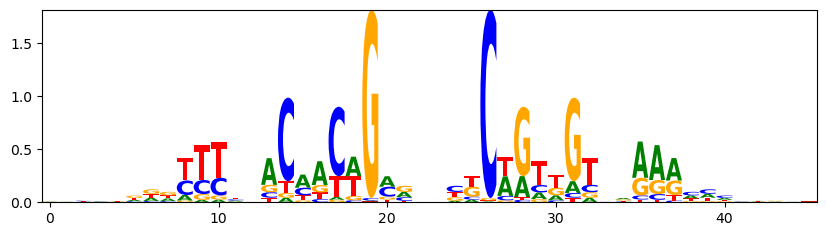

In [336]:
weighted_df_transformed = logomaker.transform_matrix(weighted_df, from_type='counts', to_type='information')
weighted_logo = logomaker.Logo(weighted_df_transformed)
plt.savefig('weighted_logo.png')
weighted_df_transformed.to_csv('weighted_halfsite_averaged_cryptic_seq_matrix.csv',index=False)
weighted_df_transformed

## Use lightmotif to scan entire human genome w/ logo

In [18]:
# Create a count matrix from an iterable of sequences
motif = lightmotif.create(weighted_seqs)

# Create a PSSM with 0.1 pseudocounts and uniform background frequencies
pwm = motif.counts.normalize(0.1)
pssm = pwm.log_odds()

genome_file = '/data/references/hg38.fa'

# get consensus sequence by getting max of each row 
consensus_sequence = ''.join(weighted_df.idxmax(axis=1))

consensus_striped = lightmotif.stripe(consensus_sequence)

# Compute scores using the fastest backend implementation for the host machine
scores = pssm.calculate(consensus_striped)
consensus_score = scores[0]
print(consensus_score)

all_scores = []
normalized_score_threshold = 0.38

for record in SeqIO.parse(genome_file, "fasta"):
    chrom = record.id
    print(chrom)
    seq = str(record.seq).upper()
    striped = lightmotif.stripe(seq)
    seq = Seq(seq)
    # seq_rv = str(record.seq.reverse_complement()).upper()
    # Encode the target sequence into a striped matrix
    
    # striped_rv = lightmotif.stripe(seq_rv)

    # Compute scores using the fastest backend implementation for the host machine
    scores = pssm.calculate(striped)
    # scores_rv = pssm.calculate(striped_rv)
    all_scores.append([ (chrom,e+1,e+1+len(consensus_sequence)-1,str(seq[e:e+len(consensus_sequence)]),str(seq[e:e+len(consensus_sequence)].reverse_complement()), str(seq[e+22:e+24]),str(seq[e+22:e+24].reverse_complement()),(consensus_score/i)) for e,i in enumerate(scores) if (consensus_score/i) >= normalized_score_threshold])
    # all_scores.append([ (chrom,e+1,e+1+len(consensus_sequence)-1,seq_rv[e:e+len(consensus_sequence)],seq_rv[e+22:e+24],(consensus_score/i)) for e,i in enumerate(scores_rv) if (consensus_score/i) >= normalized_score_threshold])
all_scores = [item for sublist in all_scores for item in sublist]

all_scores_df = pd.DataFrame(all_scores, columns=["chrom","start","end","sequence","rv_comp_sequence","plus_strand_central_dinucleotide","minus_strand_central_dinucleotide","normalized_score"])

all_scores_df.to_csv('hg38_pwm_scores.csv',index=False)

# all_scores = []

# for record in SeqIO.parse(genome_file, "fasta"):
#     chrom = record.id
#     print(chrom)
#     seq_rv = str(record.seq.reverse_complement()).upper()
#     # Encode the target sequence into a striped matrix
#     striped_rv = lightmotif.stripe(seq_rv)

#     # Compute scores using the fastest backend implementation for the host machine
#     scores_rv = pssm.calculate(striped_rv)
#     all_scores.append([ (chrom,e+1,e+1+len(consensus_sequence)-1,seq_rv[e:e+len(consensus_sequence)],seq_rv[e+22:e+24],(consensus_score/i)) for e,i in enumerate(scores_rv) if (consensus_score/i) >= normalized_score_threshold])

# all_scores = [item for sublist in all_scores for item in sublist]

# all_scores_df = pd.DataFrame(all_scores, columns=["chrom","start","end","sequence","central_dinucleotide","normalized_score"])

# all_scores_df.to_csv('hg38_pwm_scores_minus_strand.csv',index=False)


-13.822358131408691
chr1
chr10
chr11
chr11_KI270721v1_random
chr12
chr13
chr14
chr14_GL000009v2_random
chr14_GL000225v1_random
chr14_KI270722v1_random
chr14_GL000194v1_random
chr14_KI270723v1_random
chr14_KI270724v1_random
chr14_KI270725v1_random
chr14_KI270726v1_random
chr15
chr15_KI270727v1_random
chr16
chr16_KI270728v1_random
chr17
chr17_GL000205v2_random
chr17_KI270729v1_random
chr17_KI270730v1_random
chr18
chr19
chr1_KI270706v1_random
chr1_KI270707v1_random
chr1_KI270708v1_random
chr1_KI270709v1_random
chr1_KI270710v1_random
chr1_KI270711v1_random
chr1_KI270712v1_random
chr1_KI270713v1_random
chr1_KI270714v1_random
chr2
chr20
chr21
chr22
chr22_KI270731v1_random
chr22_KI270732v1_random
chr22_KI270733v1_random
chr22_KI270734v1_random
chr22_KI270735v1_random
chr22_KI270736v1_random
chr22_KI270737v1_random
chr22_KI270738v1_random
chr22_KI270739v1_random
chr2_KI270715v1_random
chr2_KI270716v1_random
chr3
chr3_GL000221v1_random
chr4
chr4_GL000008v2_random
chr5
chr5_GL000208v1_random
chr

## Load the result from lightmotif, load cryptic seq data again, drop duplicates by sequence, merge into single dataframe, sum up counts, 

In [296]:
all_scores_df = pd.read_csv('../data/hg38_pwm_scores.csv')

# all_scores_seq_deduped = all_scores_df.drop_duplicates(subset='sequence')

# Creating the new DataFrame
all_scores_data_with_minus_strand = []
dinucleotides_to_check = ["AC", "AG", "CA", "CT", "GT", "TG"]
for index, row in all_scores_df.iterrows():
    # Plus strand row
    all_scores_data_with_minus_strand.append({
        'chrom': row['chrom'],
        'start': row['start'],
        'end': row['end'],
        'sequence': row['sequence'],
        'central_dinucleotide': row['plus_strand_central_dinucleotide'],
        'strand': '+',
        'normalized_score': row['normalized_score']
    })
    # Minus strand row
    all_scores_data_with_minus_strand.append({
        'chrom': row['chrom'],
        'start': row['start'],
        'end': row['end'],
        'sequence': row['rv_comp_sequence'],
        'central_dinucleotide': row['minus_strand_central_dinucleotide'],
        'strand': '-',
        'normalized_score': row['normalized_score']
    })

all_scores_new_df = pd.DataFrame(all_scores_data_with_minus_strand)
contains_dinucleotide_condition = all_scores_new_df[['central_dinucleotide']].isin(dinucleotides_to_check).any(axis=1)
all_scores_cs_dinucleotides_df = all_scores_new_df[contains_dinucleotide_condition]

cryptic_seq_subset_df = cryptic_seq_df[['central_dinucleotide','chrom','start','end','sequence','strand','total_count']]
contains_dinucleotide_condition = cryptic_seq_subset_df[['central_dinucleotide']].isin(dinucleotides_to_check).any(axis=1)
cryptic_seq_subset_df = cryptic_seq_subset_df[contains_dinucleotide_condition]

discovery_insilico_merged = all_scores_cs_dinucleotides_df.merge(cryptic_seq_subset_df, on=['chrom','start','end','sequence','strand','central_dinucleotide'], how='outer')

discovery_insilico_merged['total_count'] = discovery_insilico_merged['total_count'].fillna(0)
discovery_insilico_merged['normalized_score'] = discovery_insilico_merged['normalized_score'].fillna(0)


In [297]:
discovery_insilico_merged.to_csv('discovery_insilico_merged.csv',index=False)

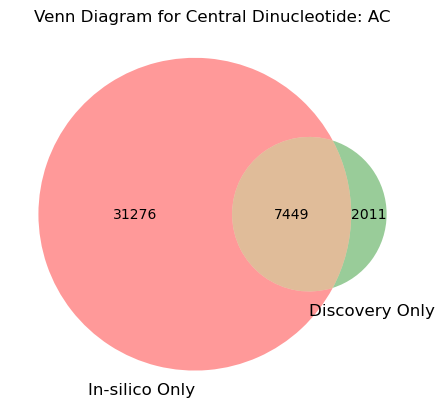

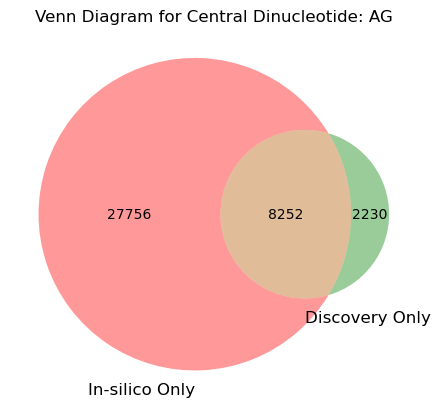

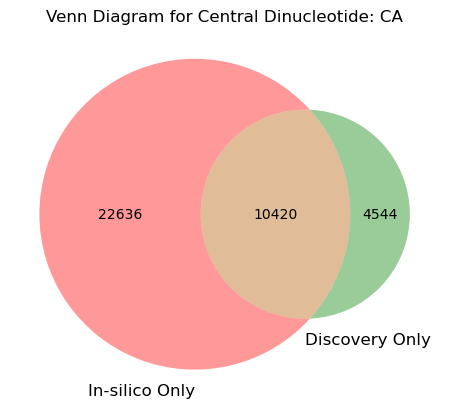

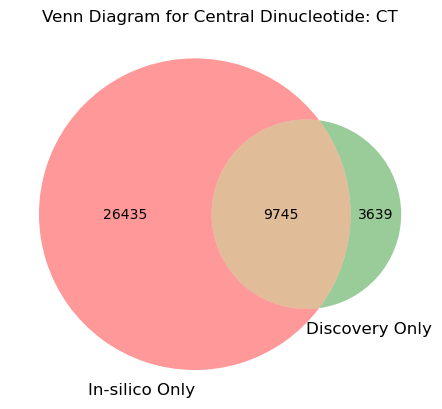

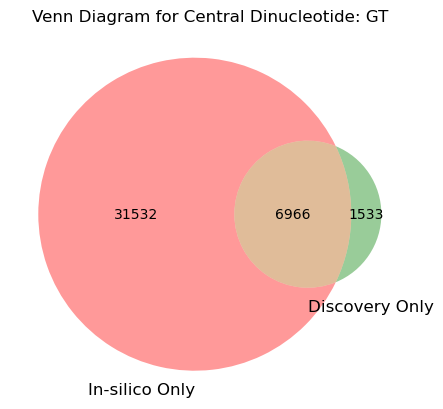

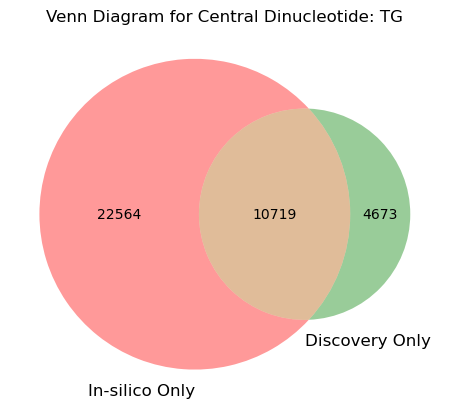

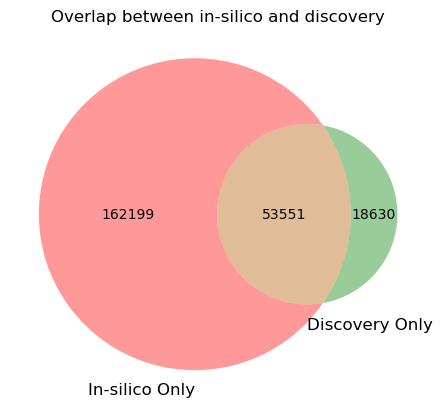

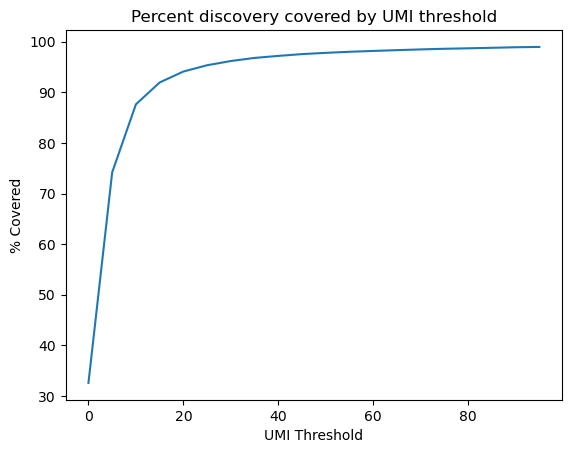

In [333]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

base_umi_threshold = 5

umi_thresholds = range(0, 100,5)

# Function to categorize sites
def categorize_sites(df, UMI_threshold):
    in_silico_only = df[(df['normalized_score'] > 0) & (df['total_count'] < UMI_threshold)]
    discovery_only = df[(df['normalized_score'] == 0) & (df['total_count'] >= UMI_threshold)]
    union = df[(df['normalized_score'] > 0) & (df['total_count'] > 0)]
    return in_silico_only, discovery_only, union

dinucleotides_to_check = ["AC", "AG", "CA", "CT", "GT", "TG"]

# Filter data for only the specified dinucleotides
filtered_data = discovery_insilico_merged[discovery_insilico_merged['central_dinucleotide'].isin(dinucleotides_to_check)]

# Initialize counts for the combined Venn diagram
combined_count_in_silico_only = 0
combined_count_discovery_only = 0
combined_count_union = 0

# Analyze each dinucleotide separately and accumulate counts for the combined diagram
for dinucleotide in dinucleotides_to_check:
    df_dinucleotide = filtered_data[filtered_data['central_dinucleotide'] == dinucleotide]
    in_silico_only, discovery_only, union = categorize_sites(df_dinucleotide,base_umi_threshold)

    # Update combined counts
    combined_count_in_silico_only += len(in_silico_only)
    combined_count_discovery_only += len(discovery_only)
    combined_count_union += len(union)

    # Count for each category for individual dinucleotide
    count_in_silico_only = len(in_silico_only)
    count_discovery_only = len(discovery_only)
    count_union = len(union)

    # Prepare the counts for the venn2 function for individual dinucleotide
    venn_counts_individual = (count_in_silico_only, count_discovery_only, count_union)

    # Plot the Venn diagram for individual dinucleotide
    plt.figure()
    venn2(subsets=venn_counts_individual, set_labels=('In-silico Only', 'Discovery Only'))
    plt.title(f"Venn Diagram for Central Dinucleotide: {dinucleotide}")
    plt.show()

percent_discovery_covered_by_umi_threshold = []
for umi_threshold in umi_thresholds:
    in_silico_only, discovery_only, union = categorize_sites(filtered_data,umi_threshold)
    percent_discovery_covered_by_umi_threshold.append(100*len(union) / (len(union) + len(discovery_only)))

# Prepare the counts for the combined Venn diagram
combined_venn_counts = (combined_count_in_silico_only, combined_count_discovery_only, combined_count_union)

# Plot the combined Venn diagram
plt.figure()
venn2(subsets=combined_venn_counts, set_labels=('In-silico Only', 'Discovery Only'))
plt.title("Overlap between in-silico and discovery")
plt.show()

plt.figure()
plt.plot(umi_thresholds,percent_discovery_covered_by_umi_threshold)
plt.title("Percent discovery covered by UMI threshold")
plt.xlabel('UMI Threshold')
plt.ylabel('% Covered')
plt.show()


TCTATCTATTCCTCCCTCTGTGTGCCGTTGCCAGTATCACCATCTT
AAGATGGTGATACTGGCAACGGCACACAGAGGGAGGAATAGATAGA
AGAAAAATGCTTTTTCTGGGAGTGCTCTAATGTCACCAAACCTCCA
GCTATGAGCTTCCACTCCCGAGTGCTGGGACACCAGGATCTAGGGG
TGGAGGTTTGGTGACATTAGAGCACTCCCAGAAAAAGCATTTTTCT
CCCCTAGATCCTGGTGTCCCAGCACTCGGGAGTGGAAGCTCATAGC
CTTAAAGAGCTTTCACATTCAGGTCTCTACAGGAGAAGACGAGATC
TCCCTAGGATCTGCCTACAGGGTGCTTTGTGACATATCCCTGCAAT
AATGTTTCCTACCATTCAAAGGAGCTCAGTTACTTAAGCTAGAAAC
GATCTCGTCTTCTCCTGTAGAGACCTGAATGTGAAAGCTCTTTAAG
CCACATGTGATGATTGAGCTCTCTCTCTGCTGTTCAGGCATGTGGC
AACCTATTTGTTTCAACAGTCTTGCTCTGTCGTCCAGGCTGGTGTG
ACTGAATTGTGTCCCCCTGCCCCACTCATATGTTGAAGCTCTAATC
TGCCATGTGAGTGCACAGTGAGAGGGCAGCCGTCTACAAGCCAGGA
GTTTTGAAAACCACTGCACACACACACACACACACACACACACATT
CGGGGCTGCTTCTCCTGGGGCCTGGGCCGTTACAGGGTGAACACGA
AACATGGGGTCCACTCTAGGACTGGGCGGCAGGAGAAGCTGGGAGC
CCTGAGTTTGTAAACAACAGAGCACTCCTAATATCTCCCCCAAGGG
CACTCCAGCCTGGACAGCGGAGTGAGACTCTGTCCCCAAACCCCCA
TGGGGGTTTGGGGACAGAGTCTCACTCCGCTGTCCAGGCTGGAGTG
TCAAAAGCACCTAACGACAGCCCACACATGCTAATGCAAACATAAT
TACTCCAGCTTGG

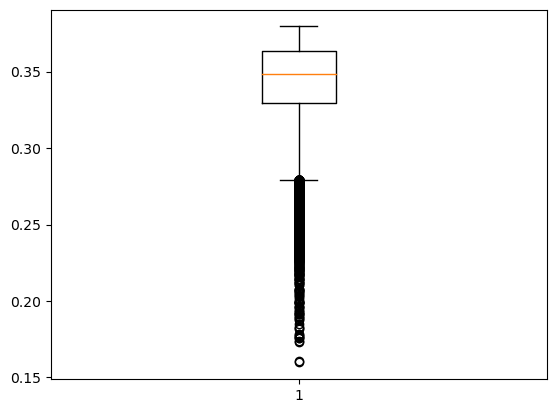

In [334]:
# Create a count matrix from an iterable of sequences
motif = lightmotif.create(weighted_seqs)

# Create a PSSM with 0.1 pseudocounts and uniform background frequencies
pwm = motif.counts.normalize(0.1)
pssm = pwm.log_odds()


# get consensus sequence by getting max of each row 
consensus_sequence = ''.join(weighted_df.idxmax(axis=1))
consensus_striped = lightmotif.stripe(consensus_sequence)
# Compute scores using the fastest backend implementation for the host machine
scores = pssm.calculate(consensus_striped)
consensus_score = scores[0]


discovery_only_scores = []
for index,row in discovery_insilico_merged[(discovery_insilico_merged['normalized_score'] == 0) & (discovery_insilico_merged['total_count'] > 0)].iterrows():
    if 'chr' not in row.chrom:
        continue
    sequence = row['sequence']
    test_striped = lightmotif.stripe(sequence)
    # Compute scores using the fastest backend implementation for the host machine
    scores = pssm.calculate(test_striped)
    test_score = scores[0]
    if (consensus_score/test_score) < 0.3:
        print(sequence)
    discovery_only_scores.append(consensus_score/test_score)

plt.boxplot(discovery_only_scores)
plt.show()



In [340]:
for i,seq in enumerate(in_silico_only.sequence):
    print(seq)
    if i == 1000:
        break

TTTTTTTTTTTGAGCAGCAGCAAGATTTATTGTGAAGAGTGAAAGA
TCTTTCACTCTTCACAATAAATCTTGCTGCTGCTCAAAAAAAAAAA
CAAGATGGCCTCACTCACAGGACTGGCTGTTGATGGGAGCCTTGAT
ATCAAGGCTCCCATCAACAGCCAGTCCTGTGAGTGAGGCCATCTTG
CAAGATGGCCTCACTCACAGGACTGGCTGTTGATGGGAGCCTTGAT
ATCAAGGCTCCCATCAACAGCCAGTCCTGTGAGTGAGGCCATCTTG
GAAGCTGATTTTCTTCATAGCACTTGCTGCCATAGAGATACATTTG
CAAATGTATCTCTATGGCAGCAAGTGCTATGAAGAAAATCAGCTTC
CAAGATGGCCTCACTCACAGGACTGGCTGTTGATGGGAGCCTTGAT
ATCAAGGCTCCCATCAACAGCCAGTCCTGTGAGTGAGGCCATCTTG
AAGAAGAGACATTAAAACTGATACCACAGAAGTTAAAAAATCATAA
TTATGATTTTTTAACTTCTGTGGTATCAGTTTTAATGTCTCTTCTT
CAGAAGGTTACCAACATCAGAAACCACAGGTAGATAAATCCATGAA
TTCATGGATTTATCTACCTGTGGTTTCTGATGTTGGTAACCTTCTG
GAAGCTGATTTTCTTCATAGCACTTGCTGCCATAGAGATACATTTG
CAAATGTATCTCTATGGCAGCAAGTGCTATGAAGAAAATCAGCTTC
CAAGATGGCCTCACTCACAGGACTGGCTGTTGATGGGAGCCTTGAT
ATCAAGGCTCCCATCAACAGCCAGTCCTGTGAGTGAGGCCATCTTG
AAGAAGAGACATTAAAACTGATACCACAGAAGTTAAAAAATCATAA
TTATGATTTTTTAACTTCTGTGGTATCAGTTTTAATGTCTCTTCTT
CAGAAGGTTACCAACATCAGAAACCACAGGTAGATAAATCCATGAA
TTCATGGATTTAT

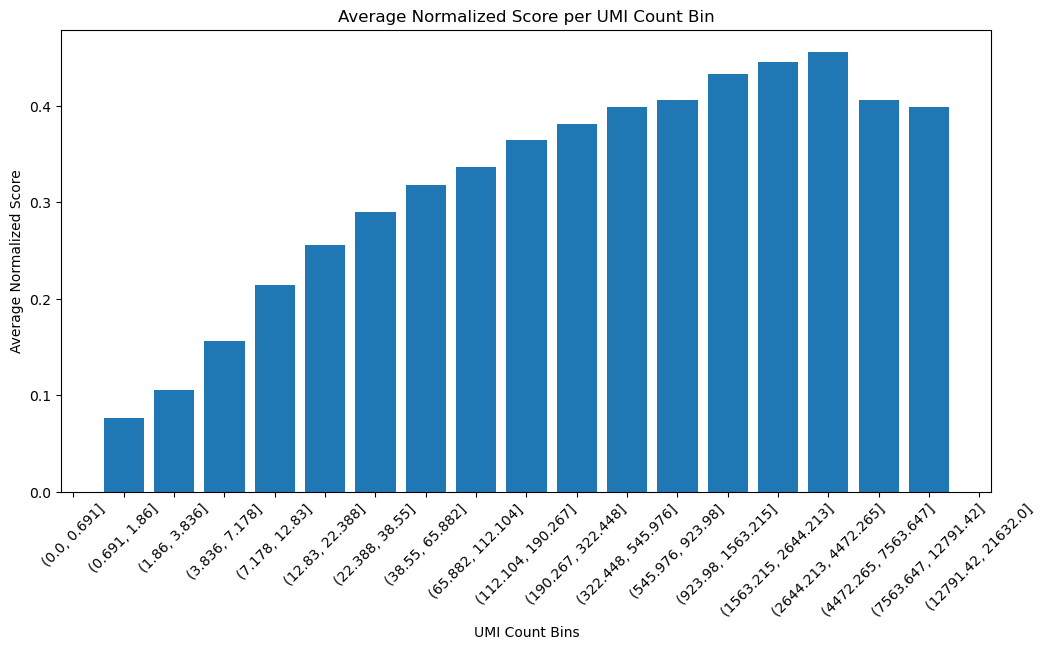

In [319]:

# Define bins for total_count
# Using a logarithmic scale due to the skew in the data
bin_edges = np.logspace(np.log10(discovery_insilico_merged['total_count'].min() + 1), 
                        np.log10(discovery_insilico_merged['total_count'].max() + 1), 
                        20) - 1
bin_edges[0] = 0  # Adjust the first bin to start from 0

# Create a new column in the dataset for the binned total_count
discovery_insilico_merged['total_count_bin'] = pd.cut(discovery_insilico_merged['total_count'], bins=bin_edges)

# Calculate the average normalized_score for each bin
average_scores_per_bin = discovery_insilico_merged.groupby('total_count_bin')['normalized_score'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(average_scores_per_bin['total_count_bin'].astype(str), average_scores_per_bin['normalized_score'])
plt.xticks(rotation=45)
plt.xlabel('UMI Count Bins')
plt.ylabel('Average Normalized Score')
plt.title('Average Normalized Score per UMI Count Bin')
plt.show()

In [306]:
all_scores_df[all_scores_df.sequence == 'GTTTGTACCGTACACCACTGAGACCGCGGTGGTTGACCAGACAAAC']

,chrom,start,end,sequence,rv_comp_sequence,plus_strand_central_dinucleotide,minus_strand_central_dinucleotide,normalized_score


In [11]:
cryptic_df = pd.read_csv('../data/cryptic_db.csv')
cryptic_df.columns = ['id','chrom','start','end','strand']
cryptic_df.sort_values('start')

,id,chrom,start,end,strand
11835,CAS6022,chrUn_KI270435v1,11806,11851,+
13820,CAS16167,chr5,38437,38482,+
7035,CAS16899,chr5,38437,38482,-
10542,CAS1563,chr14_GL000225v1_random,40931,40976,-
11748,CAS1564,chr14_GL000225v1_random,49321,49366,-
...,...,...,...,...,...
10879,CAS15929,chr1,247926592,247926637,-
1642,CAS14747,chr1,247926592,247926637,+
6883,CAS518,chr1,247940622,247940667,+
7654,CAS519,chr1,248115989,248116034,+


In [12]:
# merge cryptic site df with predictions
all_scores_with_cas_site_df = all_scores_new_df.merge(cryptic_df, on=['chrom', 'start', 'end','strand'], how='left')

# If there's no match, the "id" should be an empty string
all_scores_with_cas_site_df['id'].fillna('', inplace=True)

# Reordering columns to put "id" as the fourth column
all_scores_with_cas_site_subset_df = all_scores_with_cas_site_df[['chrom', 'start', 'end', 'id', 'normalized_score','strand']]

# create 6 column BED file
all_scores_with_cas_site_subset_df.to_csv('predicted_sites_with_cas_ids.bed',sep='\t',index=False,header=False)

In [50]:
#!/usr/bin/env python

import os
import re
import sys
import argparse
import pandas as pd
import pybedtools
import numpy as np    


def get_threat_tier(row):
    """"""
    assert len(row.feature) == len(row.group)

    if row.feature == row.group == ['.']:
        return 'IV'
    elif 'CDS' in row.feature: # and site_overlaps_protein_coding(row):
        return 'I'
    elif site_overlaps_protein_coding(row):
        return 'II'
    elif site_overlaps_non_coding(row):
        return 'III'
    else:
        raise

def site_overlaps_protein_coding(row):
    """"""
    if not 'gene' in row.feature: raise
    for feature,group in zip(row.feature,row.group):
        if feature == 'gene':
            result = parse_group(group)
            if result['gene_biotype'] == 'protein_coding':
                return True

def site_overlaps_non_coding(row):
    """"""
    if not 'gene' in row.feature: raise
    biotypes = []
    for feature,group in zip(row.feature,row.group):
        if feature == 'gene':
            result = parse_group(group)
            biotypes.append(result['gene_biotype'])
    if not 'protein_coding' in biotypes:
        return True

def overlap_gene(row):
    if not 'gene' in row.feature:
        return
    df = pd.DataFrame({'feature': row.feature, 'group': row.group, 'strand': row._strand})
    genes = []
    for i,d in df.iterrows():
        if d.feature == 'gene':
            result = parse_group(d.group)
            gene_id = result['gene_id']
            gene_biotype = result['gene_biotype']
            genes.append(f'{gene_id},{d.strand},{gene_biotype}')
    return '; '.join(genes)

def overlapping_feature(row):
    """"""
    if not 'gene' in row.feature:
        # no gene overlap
        return
    elif not 'exon' in row.feature:
        # gene overlap but no exon, must be intron
        return 'intron'
    elif 'CDS' in row.feature:
        # CDS overlap
        return 'CDS'
    for feature,group in zip(row.feature,row.group):
        result = parse_group(group)
        if feature == 'exon' and result['transcript_biotype'] == "mRNA":
            # no CDS, exon overlap in protein_coding must be UTR
            return 'UTR'
    if 'exon' in row.feature:
        # exon in transcript_biotype other than mRNA
        return 'non_coding_exon'
    else:
        raise

def parse_group(group):
    """"""
    # Regex pattern to match key-value pairs
    pattern = r'(\w+)\s+"([^"]*)"\s*;'
    # Find all matches using the pattern
    matches = re.findall(pattern, group)
    # Create a dictionary of key-value pairs
    return dict(matches)

def same_strand(row):
    if row.overlap_gene:
        gene_strand_set = set()
        for gene in row.overlap_gene.split('; '):
            gene_id,gene_strand,biotype = gene.split(',')
            gene_strand_set.add(gene_strand)
        if len(gene_strand_set) > 1:
            return 'both'
        elif row.strand in gene_strand_set:
            return 'yes'
        elif row.strand not in gene_strand_set:
            return 'no'
        else:
            print(gene_strand_set)
            raise

def closest_gene(row):
    if not 'gene' in row.feature:
        return
    df = pd.DataFrame({'feature': row.feature, 'group': row.group, 'strand': row._strand, 'distance': row.distance})
    genes = []
    for i,d in df.iterrows():
        if d.feature == 'gene':
            result = parse_group(d.group)
            gene_id = result['gene_id']
            genes.append(f'{gene_id},{d.strand},{d.distance}')
    return '; '.join(genes)

if __name__ == "__main__":

    gtf_file = '/data/references/GCF_000001405.40_GRCh38.p14_genomic.gtf.UpdateGffContigNames.gtf.sorted.gtf'
    bed_file = 'predicted_sites_with_cas_ids.bed'

    # load input file
    print('Loading BED file...')
    bed = pybedtools.BedTool(bed_file)
    # print(bed)

    # intersect sites with gff using BedTool.intersect
    names = ['chrom', 'start', 'end', 'name', 'score', 'strand']
    names += 'seqname source feature _start _end _score _strand frame group'.split()


    print('Intersecting sites with gff using BEDTools...')
    intersected_df = bed.sort().intersect(b=gtf_file, sorted=False, wb=True, loj=True).to_dataframe(names=names)

    # group by guide name and collapse columns feature and group as lists
    # each row now corresponds to a unique site, and contains the list of overlapping features
    print('Grouping by guide name and collapsing columns...')
    by_fields = 'chrom start end score strand'.split()
    grouped_data = intersected_df.groupby(by_fields).agg({'feature': list, 'group': list, '_strand': list}).reset_index()

    print('Length of BED:', len(bed))
    print('Length of grouped data:', len(grouped_data))

    # make sure all sites are here
    assert len(bed) == len(grouped_data)

    print('Getting threat tier for each site...')
    # get thread tier for each site
    # the tier is based on the overlaps returned by BedTool.intersect. Briefly,
    # if a site overlaps with CDS it returns Tier I
    # else if overlaps with a coding gene, returns Tier II
    # else if overlaps with a gene whose biotype is other than protein_coding, returns Tier III
    # else if site overlaps no features in the gtf file, returns IV
    grouped_data['threat_tier'] = grouped_data.apply(get_threat_tier, axis=1)
    # get overlapping gene and the corresponding feature (CDS,intron,UTR,non_coding_exon)
    print('Getting overlapping gene for each site...')
    grouped_data['overlap_gene'] = grouped_data.apply(overlap_gene, axis=1)
    print('Getting overlapping feature for each site...')
    grouped_data['overlapping_feature'] = grouped_data.apply(overlapping_feature, axis=1)
    print('Getting same strand for each site...')
    grouped_data['same_strand'] = grouped_data.apply(same_strand, axis=1)

    cols_df1 = 'chrom start end score strand threat_tier overlap_gene overlapping_feature same_strand'.split()
    df1 = grouped_data[cols_df1]

    print('Finding closest gene...')
   
    assert len(bed) == len(df1)

    output_fn = bed_file.split('.')[0] + '_gene_overlaps.csv'

    df1.columns = df1.columns.str.replace('_', ' ')

    print(df1.columns)
    
    df1 = df1.merge(cryptic_df, on=['chrom', 'start', 'end','strand'], how='left')

    # If there's no match, the "id" should be an empty string
    df1['id'].fillna('', inplace=True)

    df1 = df1.merge(all_scores_new_df[['chrom','start','end','strand','central_dinucleotide']],on=['chrom', 'start', 'end','strand'], how='left')

    df1.to_csv(output_fn,index=False)

    pybedtools.helpers.cleanup(verbose=False, remove_all=False)


Finding closest gene...
Index(['chrom', 'start', 'end', 'score', 'strand', 'threat tier',
       'overlap gene', 'overlapping feature', 'same strand'],
      dtype='object')


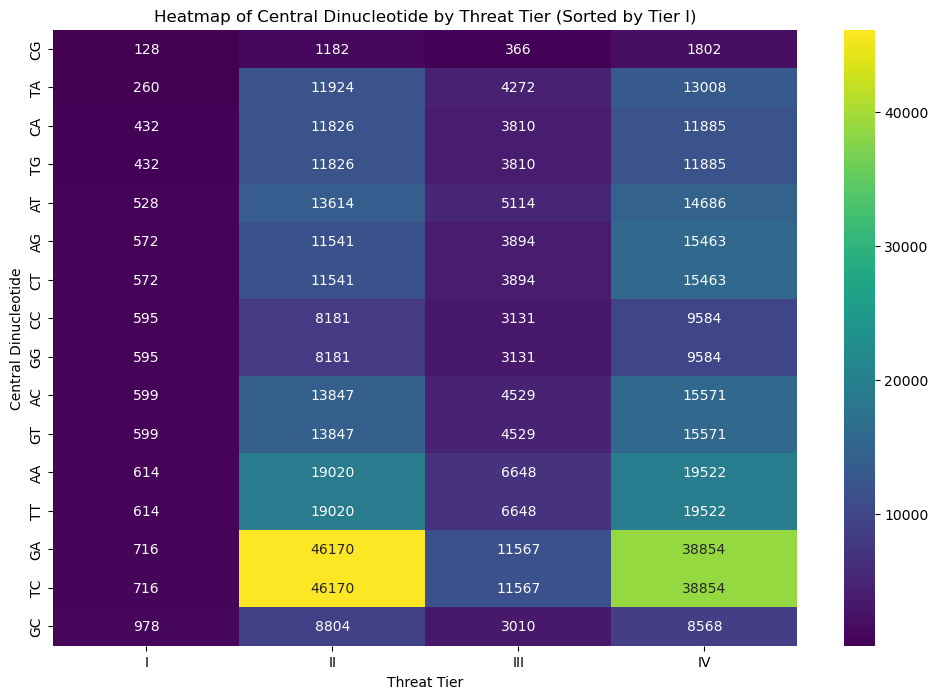

In [19]:
import seaborn as sns 

df1 = pd.read_csv('/data/cryptic_prediction/notebooks/predicted_sites_with_cas_ids_gene_overlaps.csv')
# Calculate the frequency of each central dinucleotide within each threat tier
frequency_table = pd.crosstab(df1['central_dinucleotide'], df1['threat tier'])

# Sort the frequency table by the number of Threat Tier "I" values
sorted_frequency_table = frequency_table.sort_values(by='I', ascending=True)

# Generate the heatmap with the sorted data
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_frequency_table, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Central Dinucleotide by Threat Tier (Sorted by Tier I)')
plt.xlabel('Threat Tier')
plt.ylabel('Central Dinucleotide')
plt.show()


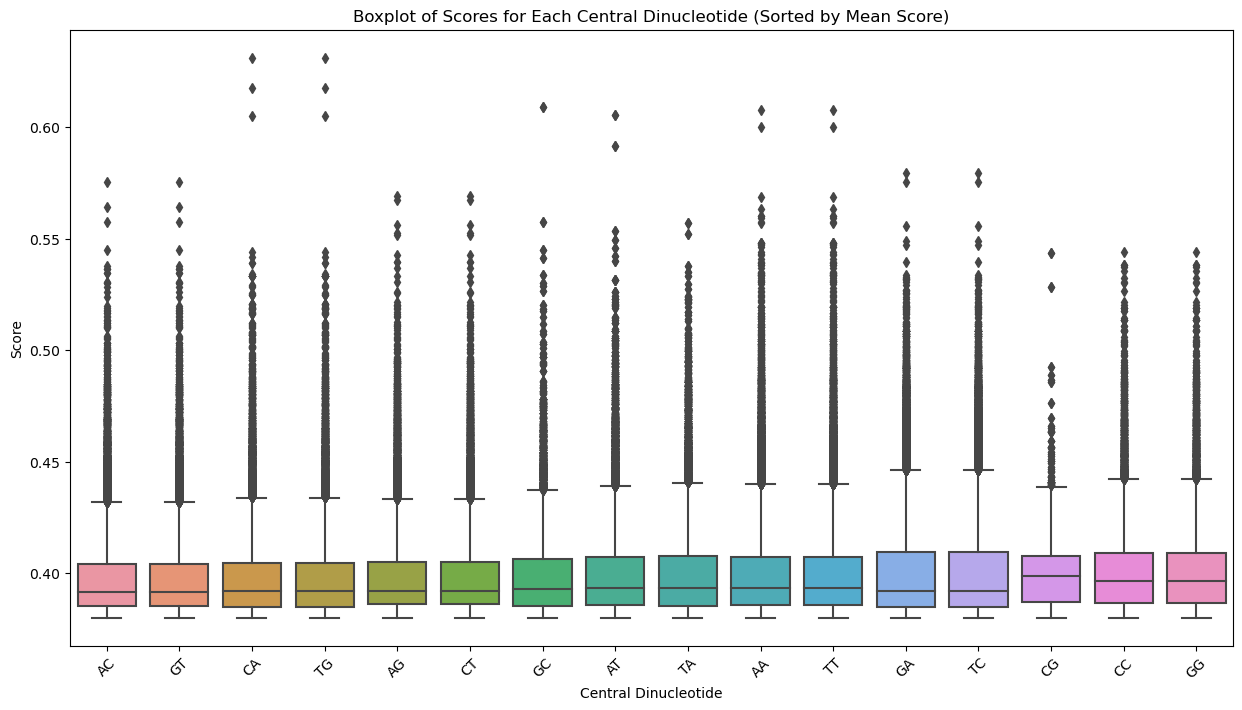

In [14]:
# Calculate the mean score for each central dinucleotide
mean_scores = df1.groupby('central_dinucleotide')['score'].mean().sort_values()

# Sort the dataset based on the order of mean scores
sorted_data = df1.set_index('central_dinucleotide').loc[mean_scores.index].reset_index()

# Create the sorted boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(x='central_dinucleotide', y='score', data=sorted_data)
plt.title('Boxplot of Scores for Each Central Dinucleotide (Sorted by Mean Score)')
plt.xlabel('Central Dinucleotide')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()


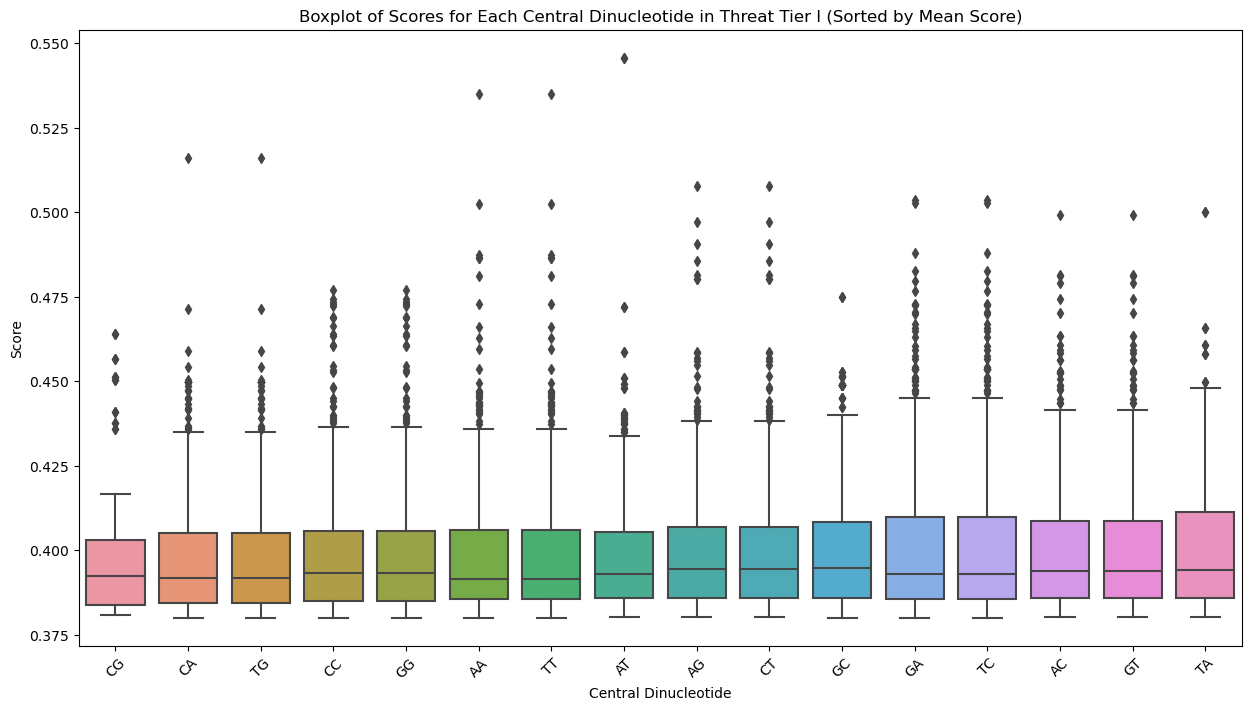

In [15]:
# Filter the dataset for Threat Tier "I"
tier_I_data = df1[df1['threat tier'] == 'I']

# Calculate the mean score for each central dinucleotide in Tier I
mean_scores_tier_I = tier_I_data.groupby('central_dinucleotide')['score'].mean().sort_values()

# Sort the Tier I dataset based on the order of mean scores
sorted_tier_I_data = tier_I_data.set_index('central_dinucleotide').loc[mean_scores_tier_I.index].reset_index()

# Create the sorted boxplots for Tier I
plt.figure(figsize=(15, 8))
sns.boxplot(x='central_dinucleotide', y='score', data=sorted_tier_I_data)
plt.title('Boxplot of Scores for Each Central Dinucleotide in Threat Tier I (Sorted by Mean Score)')
plt.xlabel('Central Dinucleotide')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()


In [16]:
df1.sort_values(by='score',ascending=False)

,chrom,start,end,score,strand,threat tier,overlap gene,overlapping feature,same strand,id,central_dinucleotide
463105,chr6,87076239,87076284,0.631248,-,IV,NaN,NaN,NaN,NaN,TG
463104,chr6,87076239,87076284,0.631248,+,IV,NaN,NaN,NaN,NaN,CA
350561,chr3,68016972,68017017,0.617629,-,II,"TAFA1,+,protein_coding",intron,no,CAS10429,CA
350560,chr3,68016972,68017017,0.617629,+,II,"TAFA1,+,protein_coding",intron,yes,CAS10409,TG
505318,chr7,99675411,99675456,0.608932,+,II,"ZSCAN25,+,protein_coding; CYP3A5,-,protein_coding",intron,both,CAS5436,GC
...,...,...,...,...,...,...,...,...,...,...,...
169223,chr15,34145957,34146002,0.380000,-,II,"KATNBL1,-,protein_coding",intron,yes,NaN,CC
510739,chr7,127671610,127671655,0.380000,-,II,"SND1,+,protein_coding",intron,no,NaN,GA
510738,chr7,127671610,127671655,0.380000,+,II,"SND1,+,protein_coding",intron,yes,NaN,TC
72927,chr10,130154155,130154200,0.380000,-,II,"GLRX3,+,protein_coding",intron,no,NaN,TT


In [20]:
merged_df_subset = merged_df[['chrom','seq_start','seq_end',"genome_dinucleotide",'strand','total_count']]
merged_df_subset.columns = ['chrom','start','end','central_dinucleotide','strand','total_count']

df1 = df1.merge(merged_df_subset,on=['chrom', 'start', 'end','central_dinucleotide','strand'], how='left')
df1 = df1.merge(all_scores_new_df, on=['chrom', 'start', 'end','central_dinucleotide','strand'], how='left')